In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:2]

['emma', 'olivia']

In [6]:
stoi = {s:i+1 for i,s in enumerate(list(sorted(set(''.join(words)))))}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [67]:
block_size = 3 # number of input characters to predict next
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # move the context window one char ahead
X = torch.tensor(X)
Y = torch.tensor(Y)

In [68]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [69]:
# embedding vector
C = torch.randn(27, 2)

In [70]:
C[[5,6,7]] # get the embedding for the characters in context

tensor([[ 0.4768,  1.8575],
        [-0.3632,  0.9258],
        [ 0.5885, -0.2454]])

In [71]:
emb = C[X] # get embedding vector for each example in X
emb.shape

torch.Size([228146, 3, 2])

In [72]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [73]:
emb[:, 0, :].shape # 1st char in the context for all examples

torch.Size([228146, 2])

In [74]:
(emb.view(-1, 6) @ W1).shape

torch.Size([228146, 100])

In [75]:
b1.shape

torch.Size([100])

In [76]:
#  32,  100
#   1,  100
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [77]:
W2 = torch.randn(100,27)
b2 = torch.randn(27)

In [78]:
logits = h @ W2 + b2

In [79]:
logits.shape

torch.Size([228146, 27])

In [80]:
counts = logits.exp()

In [81]:
prob = counts / counts.sum(1, keepdims=True)

In [82]:
prob.shape

torch.Size([228146, 27])

In [83]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [85]:
prob[torch.arange(Y.shape[0]), Y] # for each row grab the prob assigned to the expected char

tensor([4.4918e-11, 2.5118e-13, 1.6449e-08,  ..., 5.4354e-11, 2.2331e-05,
        1.4861e-05])

In [86]:
loss = -prob[torch.arange(Y.shape[0]), Y].log().mean()
loss

tensor(16.1290)

In [139]:
# embedding vector
C = torch.randn(27, 2)
# weights n biases
W1 = torch.randn(6, 100)
b1 = torch.randn(100)
W2 = torch.randn(100,27)
b2 = torch.randn(27)
params = [C, W1, b1, W2, b2]

In [140]:
sum(p.nelement() for p in params)

3481

In [141]:
for p in params:
    p.requires_grad = True

In [142]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre # 10^-3 to 10^0

In [146]:
batch_size = 256
lrs_ = []
losses = []
for i in range(10000):
    ix_batch = torch.randint(0,X.shape[0],(batch_size,))
    X_batch = X[ix_batch]
    Y_batch = Y[ix_batch]
    emb = C[X_batch]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch)

    for p in params:
        p.grad = None
    loss.backward()
    for p in params:
        # p.data -= lrs[i] * p.grad
        p.data -= 0.0001 * p.grad
    # lrs_.append(lrs[i])
    # losses.append(loss.item())
    print(loss.item())

2.5044469833374023
2.364823579788208
2.3512749671936035
2.3882644176483154
2.3356449604034424
2.3877296447753906
2.3373029232025146
2.308438777923584
2.383695602416992
2.4204094409942627
2.433462381362915
2.4150538444519043
2.3504035472869873
2.2507200241088867
2.2888240814208984
2.3901243209838867
2.37103533744812
2.5333588123321533
2.3639767169952393
2.438044786453247
2.2873337268829346
2.3345820903778076
2.326246738433838
2.4948010444641113
2.3478758335113525
2.4432547092437744
2.4593262672424316
2.411140203475952
2.3895394802093506
2.399796485900879
2.438565731048584
2.522740125656128
2.4671835899353027
2.4982433319091797
2.45992112159729
2.4268500804901123
2.415254592895508
2.3996129035949707
2.3565421104431152
2.4643070697784424
2.3994667530059814
2.417078971862793
2.485297441482544
2.52791428565979
2.465012311935425
2.412687301635742
2.5881075859069824
2.4024300575256348
2.513847827911377
2.3800859451293945
2.4343414306640625
2.4138190746307373
2.3910272121429443
2.3459405899047

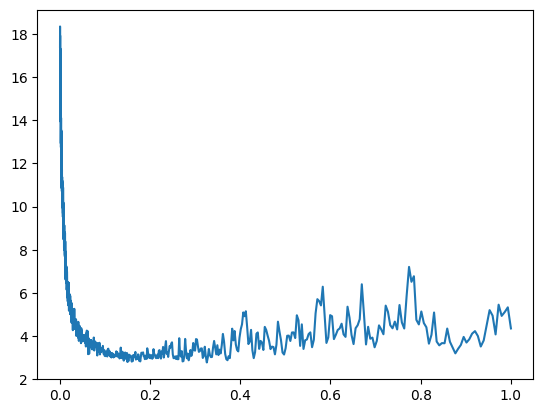

In [133]:
plt.plot(lrs_, losses) # find good learning rate

In [147]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4073, grad_fn=<NllLossBackward0>)